# Introduzione
Essere in grado di predire l'andamento di un'epidemia con un alto grado di precisione è essenziale per poter rispondere in modo pronto e ottimale all'evento. La modellizzazione statistica, in particolare l'inferenza bayesiana, fornisce uno strumento affidabile per distillare le informazioni contenute nei dati misurati nel mondo reale in un singolo modello matematico che può essere prontamente usato per compiere predizioni sul breve e lungo termine. Questo notebook utilizza questa tecnica, sfruttando un algoritmo di Monte Carlo a catena di Markov per esplorare lo spazio dei parametri e raggiungere una conclusione ottimale sulla correttezza e precisione del modello così prodotto. Si vedrà quanto questi modelli siano capaci di generalizzare al di là dei dati su cui sono stati concepiti e se dunque sono utilizzabili per predire con buona certezza l'andamento di una pandemia prima che questa accada.

# Parte 1
Analizziamo i dati misurati dalla Protezione Civile per capire su che genere di misure stiamo lavorando.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

/tmp/ipykernel_26548/3079533157.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Leggiamo i dati della Protezione Civile, usando la data come indice di time-series
data_full = pd.read_csv("./../data/dpc-covid19-ita-regioni.csv", index_col="data", parse_dates=True)
data_full.head()

,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,...,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,codice_nuts_1,codice_nuts_2
data,,,,,,,,,,,,,,,,,,,,,
2020-02-24 18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-24 18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-24 18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-24 18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-24 18:00:00,ITA,8,Emilia-Romagna,44.494367,11.341721,10,2,12,6,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Filtriamo i dati della Valle d'Aosta e sostituiamo misure di nuovi positivi minori a 0 con 0 dato che deve essere una svista
data_aosta_daily = data_full[data_full["denominazione_regione"] == "Valle d'Aosta"]
data_aosta_daily["nuovi_positivi"].map(lambda x: 0 if x < 0 else x)
data_aosta_daily.head()

,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,...,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,codice_nuts_1,codice_nuts_2
data,,,,,,,,,,,,,,,,,,,,,
2020-02-24 18:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-25 18:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-26 18:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-27 18:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-28 18:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


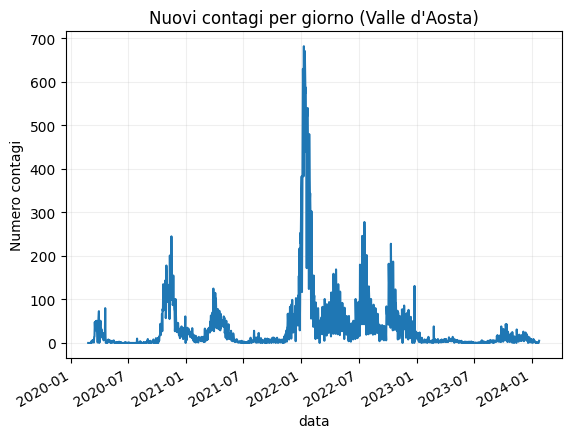

In [4]:
# Grafichiamo il numero di contagi per giorno in Val d'Aosta
data_aosta_daily["nuovi_positivi"].plot(
    title="Nuovi contagi per giorno (Valle d'Aosta)",
    ylabel="Numero contagi",
)
plt.grid(alpha=0.2)

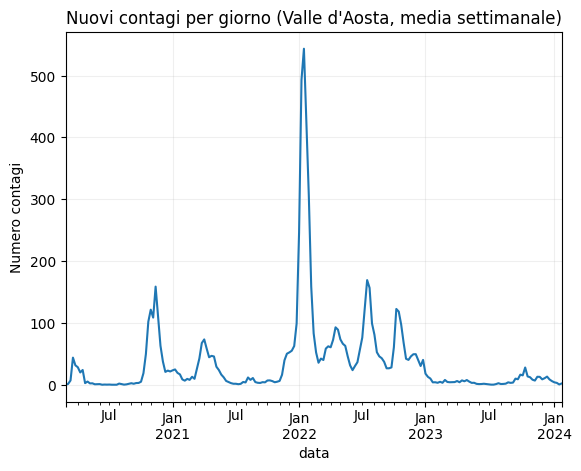

In [5]:
# I dati sono piuttosto rumorosi: conviene usare la media settimanale
data_aosta_weekly = data_aosta_daily.resample("W")
data_aosta_weekly["nuovi_positivi"].mean().plot(
    title="Nuovi contagi per giorno (Valle d'Aosta, media settimanale)",
    ylabel="Numero contagi",
)
plt.grid(alpha=0.2)

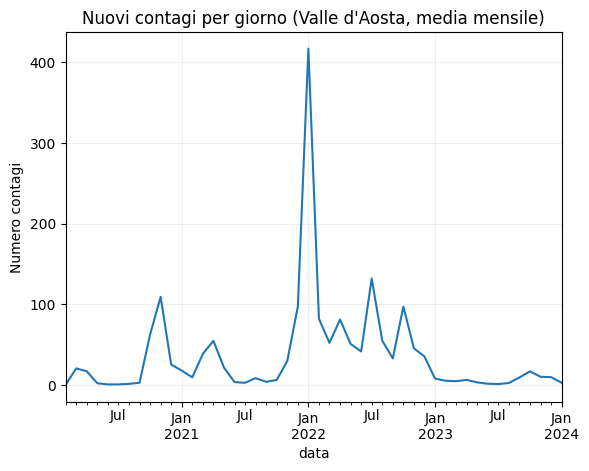

In [6]:
# La media mensile invece è troppo grezza
data_aosta_monthly = data_aosta_daily.resample("ME")
data_aosta_monthly["nuovi_positivi"].mean().plot(
    title="Nuovi contagi per giorno (Valle d'Aosta, media mensile)",
    ylabel="Numero contagi",
)
plt.grid(alpha=0.2)

# Parte 2
Definiamo le funzioni che verranno usate per l'analisi dei dati e controlliamo la loro forma in funzione dei loro parametri.

In [7]:
import numpy as np
from pandas import Timestamp, DatetimeIndex, Timedelta
from typing import Callable

In [8]:
# Definiamo una semplice funzione per poter usare l'indice del DataFrame direttamente come input invece che
# convertirlo ad un array di int manualmente
def date_diff_to_int(t: Timestamp | DatetimeIndex, t_0: Timestamp):
    """
    Funzione di convenienza che trasforma date in un intero che denota la distanza in giorni
    Argomenti:
    t (Timestamp | DatetimeIndex): un Timestamp o un DatetimeIndex di pandas
    t_0 (Timestamp): il Timestamp rispetto al quale verrà calcolata la differenza
    Nota: la differenza non è assoluta ed è negativa se t < t_0
    """
    return (t - t_0).days


La funzione logistica è definita come
$$f(t) = \frac{N_{tot}}{1 + e^{-k(t-t_{0})}}$$

In [9]:
def logistic(t: float | Timestamp | DatetimeIndex, t_0: float | Timestamp, k: float, N_tot: float):
    """
    Calcola la funzione logisitica al tempo `t`
    Argomenti:
    t (float | Timestamp | DatetimeIndex): il tempo a cui calcolare la funzione. Può anche essere un
    Timestamp scalare o un DatetimeIndex di pandas. Nel caso di un DatetimeIndex, calcola la funzione per
    ogni valore dell'indice
    t_0 (float | Timestamp): il tempo d'inizio dell'evento
    k (float): il tasso di propagazione
    N_tot (float): il numero totale di casi a fine evento
    """
    if isinstance(t, (Timestamp, DatetimeIndex)) and isinstance(t_0, Timestamp):
        diff = date_diff_to_int(t, t_0)
    else:
        diff = t - t_0
    return N_tot / (1 + np.exp(-k * diff))

La funzione di Gompertz è definita come
$$f(t)=N_{tot}e^{-\log(N_{tot})\exp(-k(t-t_{0}))}$$

In [10]:
def gompertz(t: float, t_0: float, k: float, N_tot: float):
    """
    Calcola la funzione di Gompertz al tempo `t`
    Argomenti:
    t (float | Timestamp | DatetimeIndex): il tempo a cui calcolare la funzione. Può anche essere un
    Timestamp scalare o un DatetimeIndex di pandas. Nel caso di un DatetimeIndex, calcola la funzione per
    ogni valore dell'indice
    t_0 (float | Timestamp): il tempo d'inizio dell'evento
    k (float): il tasso di propagazione
    N_tot (float): il numero totale di casi a fine evento
    """
    if isinstance(t, (Timestamp, DatetimeIndex)) and isinstance(t_0, Timestamp):
        diff = date_diff_to_int(t, t_0)
    else:
        diff = t - t_0
    return N_tot * np.exp(-np.log(N_tot) * np.exp(-k * diff))

In [11]:
# Definiamo la funzione per trovare i contagi giornalieri come una funzione generica che calcola la differenza
# per qualunque funzione gli si è data come argomento. Ciò permette di riutilizzarla sia per la logistica che la
# funzione di Gompertz
def contagi_giornalieri(func: Callable, day: float | Timestamp | DatetimeIndex, **kwargs):
    """
    Conta i contagi giornalieri predetti dalla funzione `func` tra il giorno `day` e quello successivo
    Argomenti:
    func (Callable): La funzione da campionare
    day (float | DatetimeIndex | Timestamp): Il giorno da considerare, come numero di giorni dall'inizio della pandemia
    kwargs: Gli argomenti aggiuntivi da passare alla funzione `func`
    """
    next_day = day + Timedelta(days=+1) if isinstance(day, (DatetimeIndex, Timestamp)) else day + 1
    return abs(func(next_day, **kwargs) - func(day, **kwargs))

In [12]:
x = np.linspace(-15, 15, 1000)

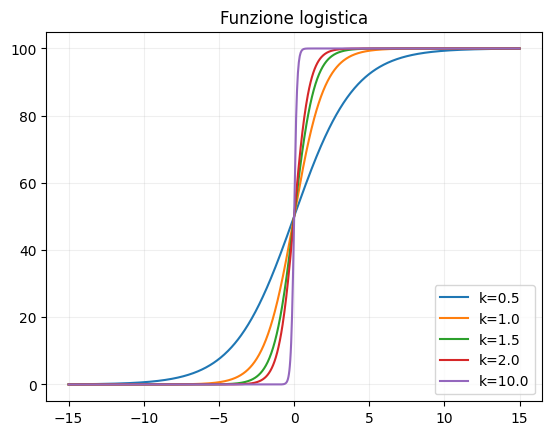

In [13]:
# Alcuni test per vedere se la funzione logistica è corretta
for k in [0.5, 1.0, 1.5, 2.0, 10.0]:
    plt.plot(x, logistic(x, 0, k, 100), label=f"k={k}")
plt.legend(loc="lower right")
plt.title("Funzione logistica")
plt.grid(alpha=0.2)

Qui vediamo la funzione logistica per diversi $k$. Si nota che la $k$ rappresenta la pendenza della curva, principalmente nella parte centrale attorno a $t_{0}$. $N_{tot}$ invece determina l'altezza a cui la funzione si stabilizza. $t_{0}$ è il centro di simmetria (dispari) della curva. Per $k\rightarrow\infty$, la funzione diventa $N_{tot}\theta(t - t_{0})$ dove $\theta(t)$ è la theta di Heaviside.

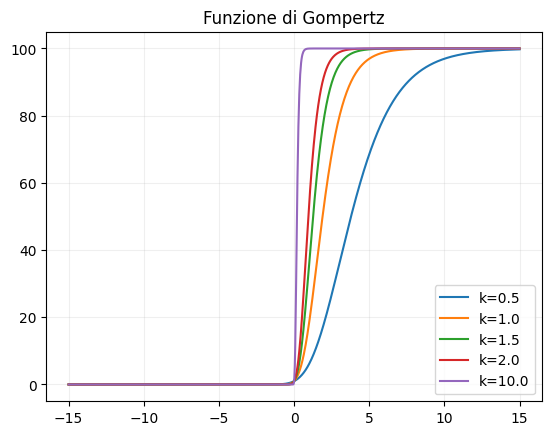

In [14]:
# Alcuni test per vedere se la funzione di Gompertz è corretta
for k in [0.5, 1.0, 1.5, 2.0, 10.0]:
    plt.plot(x, gompertz(x, 0, k, 100), label=f"k={k}")
plt.legend(loc="lower right")
plt.title("Funzione di Gompertz")
plt.grid(alpha=0.2)

I parametri della funzione di Gompertz hanno un significato molto simile a quelli della funzione logistica. $N_{tot}$ e $k$ hanno lo stesso significato, ma $t_{0}$ non è più il centro di simmetria, bensì l'inizio della curva. I valori $t<t_{0}$ sono tendenti allo zero. Anche qui vale il limite $\lim\limits_{k\rightarrow\infty}f(t)=N_{tot}\theta(t-t_{0})$.

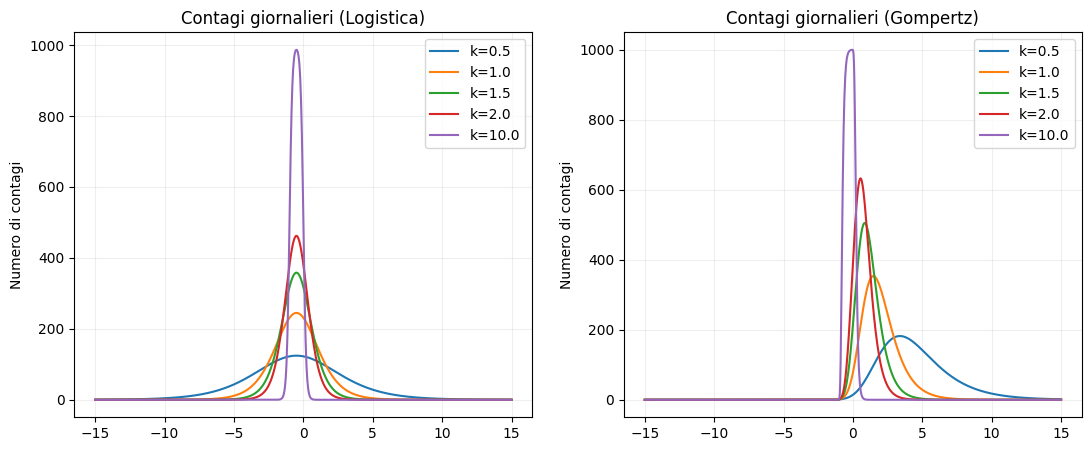

In [15]:
# Osserviamo la variazione giornaliera delle due funzioni (con diversi valori di k)
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

for k in [0.5, 1.0, 1.5, 2.0, 10.0]:
    conts_log = contagi_giornalieri(logistic, x, k=k, N_tot=1000, t_0=0)
    conts_gomp = contagi_giornalieri(gompertz, x, k=k, N_tot=1000, t_0=0)
    axes[0].plot(x, conts_log, label=f"k={k}")
    axes[1].plot(x, conts_gomp, label=f"k={k}")

axes[0].set_title("Contagi giornalieri (Logistica)")
axes[0].set_ylabel("Numero di contagi")
axes[0].legend()
axes[0].grid(alpha=0.2)

axes[1].set_title("Contagi giornalieri (Gompertz)")
axes[1].set_ylabel("Numero di contagi")
axes[1].legend()
axes[1].grid(alpha=0.2)

Sebbene non sia calcolata in modo esplicito, i contagi giornalieri sono sostanzialmente la derivata delle funzioni logistica e di Gompertz. Si può vedere come siano a tutto effetto delle distribuzioni: la logistica ha l'aspetto di una gaussiana, mentre la funzione di Gompertz ricorda una lognormale. La logistica è simmetrica e ha una crescita graduale, mentre la curva di Gompertz è asimmetrica, con una crescita repentina e una discesa più lenta.

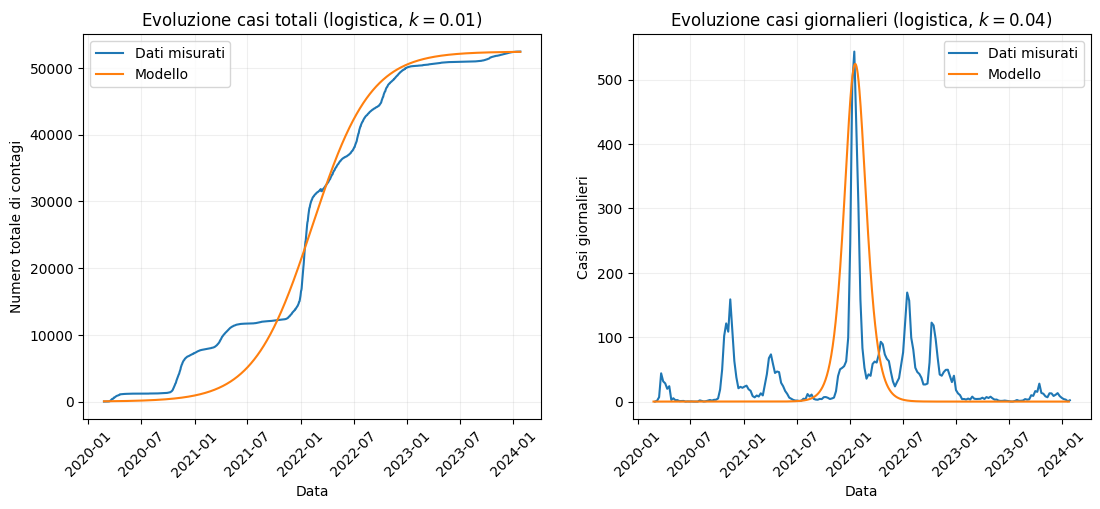

In [16]:
# Un primo tentativo completamente manuale al fittare la logistica ai dati misurati
d1 = data_aosta_daily.index
midpoint = d1[len(d1) // 2] # Prendiamo t_0 come la data a metà della pandemia
max_contagions = data_aosta_daily["totale_casi"].max() # N_tot invece è qualunque valore sia l'ultimo misurato nei casi totali

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
axes[0].plot(data_aosta_daily["totale_casi"], label="Dati misurati")
axes[0].plot(d1, logistic(d1, midpoint, 0.01, max_contagions), label="Modello")
axes[0].set_title("Evoluzione casi totali (logistica, $k=0.01$)")
axes[0].set_xlabel("Data")
axes[0].tick_params("x", rotation=45)
axes[0].set_ylabel("Numero totale di contagi")
axes[0].grid(alpha=0.2)
axes[0].legend()

axes[1].plot(data_aosta_weekly["nuovi_positivi"].mean(), label="Dati misurati")
axes[1].plot(
    d1,
    contagi_giornalieri(
        logistic,
        d1,
        t_0=midpoint + Timedelta(days=-20),
        k=0.04,
        N_tot=max_contagions,
    ),
    label="Modello",
)
axes[1].set_title("Evoluzione casi giornalieri (logistica, $k=0.04$)")
axes[1].set_xlabel("Data")
axes[1].tick_params("x", rotation=45)
axes[1].set_ylabel("Casi giornalieri")
axes[1].grid(alpha=0.2)
axes[1].legend()

Come ci si può aspettare, una curva semplice come quella logistica fatica a dare una buona approssimazione dell'andamento della pandemia durante tutto il suo corso. In particolare, la pandemia si divide chiaramente in periodi di contagi molto frequenti (ondate) e periodi "refrattari" entro il quale i contagi sono più sporadici. Ciò rende la curva dei casi giornalieri molto "accidentata", con diversi picchi e valli. Come si può vedere dal grafico di destra, la distribuzione giornaliera ottenuta dalla logistica ha un singolo picco, il che la rende inadatta a descrivere il comportamento di tutte le ondate in un singolo modello. D'altro canto, la crescita dei casi totali è approssimata con precisione molto migliore: l'unica grande imprecisione è nel primo terzo della pandemia, dove si nota un'evidente sottostima.

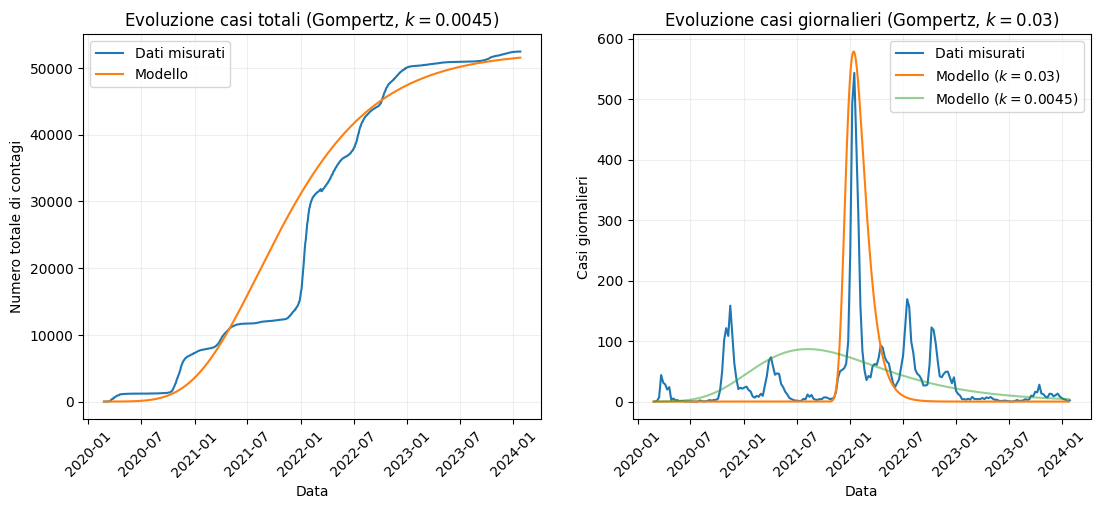

In [17]:
# Un primo tentativo completamente manuale al fittare la funzione di Gompertz ai dati misurati
d0 = data_aosta_daily.index[0] # t_0 della funzione di Gompertz è il giorno zero...
d1 = data_aosta_daily.index
midpoint = d1[len(d1) // 2] # ...ma per la sua derivata è definito come per la logistica. Chiaramente 
max_contagions = data_aosta_daily["totale_casi"].max() # N_tot definito come la logistica

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
max_contagions = data_aosta_daily["totale_casi"].max()
axes[0].plot(data_aosta_daily["totale_casi"], label="Dati misurati")
axes[0].plot(d1, gompertz(d1, d0, 0.0045, max_contagions), label="Modello")
axes[0].set_title("Evoluzione casi totali (Gompertz, $k=0.0045$)")
axes[0].set_xlabel("Data")
axes[0].tick_params("x", rotation=45)
axes[0].set_ylabel("Numero totale di contagi")
axes[0].grid(alpha=0.2)
axes[0].legend()

axes[1].plot(data_aosta_weekly["nuovi_positivi"].mean(), label="Dati misurati")
axes[1].plot( # Grafico con parametri diversi
    d1,
    contagi_giornalieri(
        gompertz,
        d1,
        t_0=midpoint + Timedelta(days=-105),
        k=0.03,
        N_tot=max_contagions,
    ),
    label="Modello ($k=0.03$)",
)
axes[1].plot( # Grafico con parametri uguali
    d1,
    contagi_giornalieri(
        gompertz,
        d1,
        t_0=d0,
        k=0.0045,
        N_tot=max_contagions,
    ),
    label="Modello ($k=0.0045$)",
    alpha=0.5
)
axes[1].set_title("Evoluzione casi giornalieri (Gompertz, $k=0.03$)")
axes[1].set_xlabel("Data")
axes[1].tick_params("x", rotation=45)
axes[1].set_ylabel("Casi giornalieri")
axes[1].grid(alpha=0.2)
axes[1].legend()

La funzione di Gompertz presenta caratteristiche simili a quelle della funzione logistica. Il singolo picco nei casi giornalieri rende impossibile avere una buona approssimazione delle ondate sebbene l'approssimazione dei casi totali sia discreta, anche se non ottima. È interessante notare come la funzione di Gompertz tenda a sovrastimare i casi totali per la maggior parte della pandemia, a differenza della logistica che tende a sottostimare il primo periodo. Non è invece possibile avere un'approssimazione utilizzabile che usi gli stessi parametri sia per la funzione cumulativa che per quella giornaliera, il che rende questa funzione completamente inadatta per formare un modello che copra tutta la pandemia da inizio a fine, come si può vedere dalla curva verde nel grafico di destra.

# Parte 3
Usiamo le funzioni definite per modellare l'andamento della pandemia, usando l'inferenza bayesiana e una catena di Montecarlo per stimare i parametri.

In [18]:
from scipy.stats import poisson
from scipy.optimize import minimize
import emcee
import corner

In [19]:
# Filtriamo i dati per tenere solo quelli dei primi 35 giorni
data_aosta_daily_early = data_aosta_daily[data_aosta_daily.index <= Timestamp(year=2020, month=3, day=30)]
data_aosta_daily_early.shape

(35, 29)

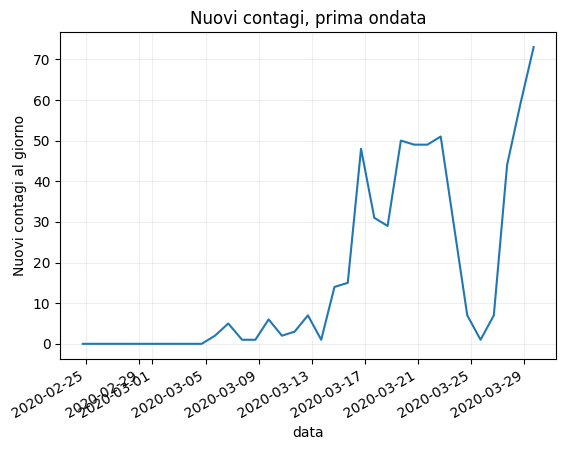

In [20]:
# Visualizziamo i dati per vedere su cosa stiamo lavorando
data_aosta_daily_early["nuovi_positivi"].plot(
    title="Nuovi contagi, prima ondata",
    ylabel="Nuovi contagi al giorno"
)
plt.grid(alpha=0.2)

I primi contagi giornalieri hanno una crescita ripida a circa due settimane dal primo caso, per poi appiattirsi momentanemente e avere un crollo di pochi giorni prima di tornare riaumentare a valori più alti di prima. I dati sono molto variabili, quindi al meglio ci si può aspettare che il modello dia una descrizione del generale andamento, ma che non sia affidabile per predire misure di giorno in giorno.

## Modello logistico
Qui cerchiamo di descrivere e modellare l'evoluzione dei contagi utilizzando la curva logistica.
Assumiamo che i parametri di tale curva siano distribuiti con una distribuzione poissoniana
$$\text{Pois}(k)=\frac{\lambda^{k}e^{-\lambda}}{k!}$$
dove $\lambda$ è il valore di aspettazione e $k$ è il numero di eventi che si vuole accadano. La forma logaritmica (nel senso del logaritmo naturale) è
$$\log\text{Pois}(k)=\log(\lambda^{k})+\log(e^{-\lambda})-\log(k!)=k\log(\lambda)-\lambda-\sum\limits_{i=2}^{k}\log(i)$$

In [21]:
# Controllo per garantire che la forma logaritmica della poissoniana sia effettivamente corretta
np.isclose(12 * np.log(8) - 8 - np.sum(np.log(np.arange(2, 13))), np.log(poisson(8).pmf(12)), atol=1e-6)

True

In [22]:
# Definiamo la struttura statistica per effettuare la ricerca dei parametri del modello
# Si usa la forma logaritmica per motivi numerici: la distribuzione di Poisson assunta come
# distribuzione dei parametri del modello richiede il calcolo di un esponenziale e di un
# fattoriale, entrambi numeri che aumentano a dismisura rapidamente e diminuiscono la precisione
# dei calcoli in poco tempo. Inoltre, c'è la possibilità che causino overflow.
# L'uso della forma logaritmica permette di limitare l'ordine di grandezza dei numeri per
# evitare bug difficili da rintracciare.

# Il prior è piuttosto scarno: sappiamo che la data t_0 non ha senso essere prima del giorno 0,
# che k non può essere negativo per definizione e che il numero totale di contagi N_tot logicamente
# non può essere negativo
def log_prior(t_0: float, k: float, N_tot: int):
    if t_0 < 0 or k < 0 or N_tot < 0:
        return -np.inf
    return 0.0

# La likelihood è data da una distribuzione poissoniana, il cui numero di eventi misurati lambda è
# dato dalla funzione logistica, o meglio dai contagi giornalieri misurati tramite la logistica
def log_likelihood(t_0: float, k: float, N_tot: int, day_from_start: int, measured_cases: int):
    lam = contagi_giornalieri(logistic, day_from_start, t_0=t_0, k=k, N_tot=N_tot)
    k_pois = measured_cases
    # Calcoliamo le somme che danno il logaritmo del fattoriale
    logfac = [np.sum(np.log(np.arange(2, k_i + 1))) for k_i in k_pois]
    return np.nansum(k_pois*np.log(lam) - lam - logfac)

# Il (log)posterior è semplicemente la somma di (log)prior e (log)likelihood
def log_posterior(params: list, day_from_start: int, measured_cases: int):
    t_0, k, N_tot = params
    prior = log_prior(t_0, k, N_tot)
    if not np.isfinite(prior):
        return -np.inf
    llh = log_likelihood(t_0, k, N_tot, day_from_start, measured_cases)
    return prior + llh

In [23]:
# Impostiamo il seme RNG per rendere i calcoli riproducibili
np.random.seed(1234)

In [24]:
# Cerchiamo il minimo della funzione posterior per migliorare il punto di partenza dell'algoritmo emcee
starting_point = np.array([0, 0.1, 1000])
min_result = minimize(
    lambda *args: -log_posterior(*args),
    starting_point,
    args=(
        np.arange(0, 35), # Giorni dall'inizio della pandemia
        data_aosta_daily_early["nuovi_positivi"],
    ),
)
min_params = min_result.x
min_params

/run/media/dawnstar/vault/vault-home/Software/Python/analisi-covid-trmd/venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


array([2.98563626e+01, 2.28548804e-01, 7.65336619e+02])

In [25]:
# L'algoritmo emcee vero e proprio, calcolato sui dati dei nuovi contagi nei primi 35 giorni
sampler = emcee.EnsembleSampler(32, 3, log_posterior, args=(np.arange(0, 35), data_aosta_daily_early["nuovi_positivi"]))
sampler.run_mcmc(min_params + 1e-2 * np.random.rand(32, 3), 4000, progress=True)

100%|████████████████████████████████████████████████████████████████████| 4000/4000 [00:39<00:00, 100.07it/s]


State([[3.02336560e+01 2.20092095e-01 7.45596036e+02]
 [2.96169438e+01 2.19364586e-01 7.37141383e+02]
 [3.01939105e+01 2.29943271e-01 7.49600387e+02]
 [2.96160027e+01 2.28322793e-01 7.85306298e+02]
 [3.00518983e+01 2.30672969e-01 7.48457810e+02]
 [2.93833333e+01 2.22770439e-01 7.43966578e+02]
 [2.97519066e+01 2.21494201e-01 8.16548207e+02]
 [2.89843743e+01 2.61218704e-01 7.50607284e+02]
 [2.91236844e+01 2.30788406e-01 6.99723877e+02]
 [2.84611929e+01 2.42851696e-01 6.76611000e+02]
 [3.08979239e+01 2.18183283e-01 8.37135070e+02]
 [2.93226748e+01 2.20763684e-01 7.34234254e+02]
 [3.03095286e+01 2.17413282e-01 8.11212743e+02]
 [3.06044198e+01 2.26969061e-01 8.07702677e+02]
 [3.07583839e+01 2.23714426e-01 7.92825531e+02]
 [3.05855214e+01 2.18201646e-01 8.70794830e+02]
 [2.89953680e+01 2.29506958e-01 7.24625932e+02]
 [3.00837998e+01 2.02130944e-01 8.52998295e+02]
 [3.04496839e+01 2.25436271e-01 8.18561019e+02]
 [2.97020084e+01 2.23526844e-01 7.76532921e+02]
 [3.08923862e+01 2.06615654e-01 7.

Text(0.5, 0, 'Numero di passi')

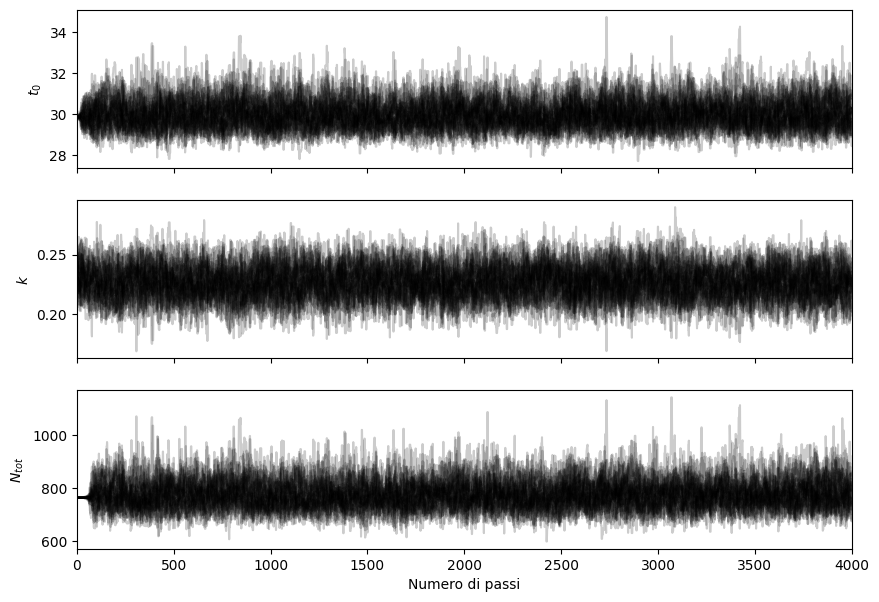

In [26]:
# Grafichiamo i risultati della catena di Monte Carlo
samples = sampler.get_chain()

dims = 3
fig, axes = plt.subplots(dims, figsize=(10, 7), sharex=True)
labels = ["$t_{0}$", "$k$", "$N_{tot}$"]
for i in range(dims):
    axes[i].plot(samples[:, :, i], "k", alpha=0.2)
    axes[i].set_xlim(0, len(samples))
    axes[i].set_ylabel(labels[i])

axes[-1].set_xlabel("Numero di passi")

L'algoritmo di minimizzazione ha correttamente portato i parametri iniziali ad un valore simile a quello più affidabile, come si può notare dal fatto che le oscillazioni accadono tutte in un intervallo centrato nel punto di partenza.

In [27]:
# Controlliamo che il tempo di autocorrelazione sia sufficientemente alto
# (ossia che emcee non dia un errore)
tau = sampler.get_autocorr_time()
tau

array([37.30947285, 37.73241539, 38.61785122])

In [28]:
# Prendiamo i valori della catena, scartando i primi 100
flat_samples = sampler.get_chain(discard=100, flat=True)
flat_samples.shape

(124800, 3)

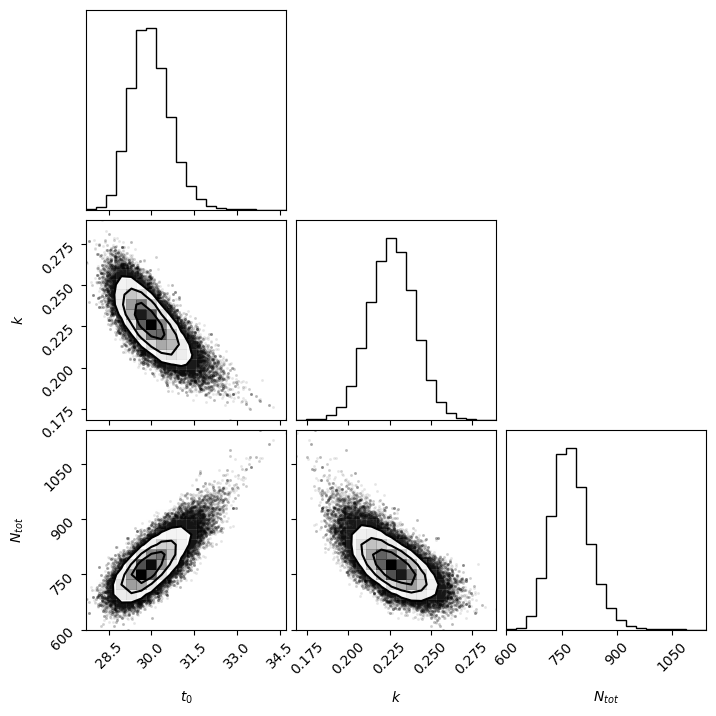

In [29]:
# Grafichiamo le combinazioni di parametri in modo da osservare le loro distribuzioni
# e notare possibili correlazioni fra di essi
fig = corner.corner(flat_samples, labels=labels)

Qui vediamo le distribuzioni dei tre parametri $t_{0}$, $k$ e $N_{tot}$, assieme alle loro covarianze. Si osserva immediatamente dalla distribuzione di $N_{tot}$ o da quella di $t_{0}$ la forma di una poissoniana, che è precisamente ciò che ci si aspetta. Più interessanti sono le proiezioni delle distribuzioni congiunte, dove si nota un'evidente e forte covarianza tra i termini: $N_{tot}$ e $t_{0}$ sono fortemente correlati, mentre $N_{tot}$ e $k$, e $t_{0}$ e $k$ sono fortemente anticorrelati.

Le correlazioni tra i parametri sono interpretabili nei seguenti modi:
1. $t_{0}$ e $N_{tot}$ sono positivamente correlati. Dal punto di vista strettamente matematico, $t_{0}$ rappresenta il centro (di simmetria) della funzione logistica, oltre che l'unico punto di flesso. Interpretandolo in chiave epidemica, esso è il momento a metà dell'epidemia (o di un'ondata, in questo caso), quindi contiene anche informazioni sulla durata di essa, che si può trovare raddoppiandolo (questo verrà confermato nei prossimi grafici). Se $t_{0}$ è grande, allora ciò implica che l'ondata durerà più a lungo ed è dunque ragionevole supporre che un'ondata lunga implichi un maggior numero di contagi avvenuti nella sua durata, quindi $N_{tot}$ più alto.
2. $k$ e $t_{0}$ sono negativamente correlati. Matematicamente, la $k$ è la pendenza della curva. Più alta è, più ripida è la curva. In termini di contagi, ciò significa un grande picco di casi in un tempo estremamente ridotto, che però rallenta quasi immediatamente per poi quasi fermarsi. Considerato che una persona infetta diventa immune a ulteriori infezioni per un certo tempo, è ragionevole assumere che un'ondata con grande infettività terminerebbe in poco tempo, in quanto il numero di persone contagiabili diminuisce tanto velocemente quanto aumenta il numero di contagi.
3. $k$ e $N_{tot}$ sono negativamente correlate. Questa connessione è più ardua da formalizzare: intuitivamente, una grande $k$, la "infettività", implica un numero più alto di infetti totali, dato che il virus si espande più rapidamente. Il modello, tuttavia, suggerisce che il caso opposto sia quello più affidabile. Una spiegazione molto grezza può essere la seguente: si prenda come metafora una candela. La fiamma è il virus e l'ossigeno che permette la combustione sono gli individui infettabili. Una fiamma più forte ($k$ alto) implica l'ossigeno venga consumato più in fretta (più contagi in poco tempo, vedi punto 2). In mancanza di misure restrittive, l'ossigeno è presente in quantità enormi e la candela è libera di bruciarne quanto vuole (contagi di massa, storicamente la norma per le epidemie come la peste o l'influenza spagnola). Tuttavia al COVID si è risposto con misure restrittive, il lockdown. Si pensi ad un bicchiere che viene poggiato attorno alla candela, racchiudendola. Ciò limita l'ossigeno a cui ha accesso (il numero di persone non immuni) e dunque tenderà a spegnersi. La velocità con cui si spegne dipende da quanto forte brucia (la $k$, di nuovo punto 2), ma è anche limitata nel numero di contagi totali che può causare e dunque $N_{tot}$. Una malattia meno pericolosa e virulenta ($k$ basso) non richiede misure così drastiche, quindi sebbene infetti meno individui nel breve termine, la mancanza di restrizioni le permetterebbe di diffondersi molto di più nel lungo termine ($t_{0}$ alto) e con più contagi totali ($N_{tot}$ alto). Questa interpretazione è intenzionalmente vaga e qualitativa. La correlazione in esame racchiude molta informazione che in questa analisi non è espressa e andrebbe utilizzato un modello che tiene conto di parametri sociali e di isolamento per essere spiegata in modo più affidabile.

In [30]:
# Troviamo i parametri più affidabili
t_0_best_fit, k_best_fit, N_tot_best_fit = np.percentile(flat_samples, 50, axis=0)
t_0_best_fit, k_best_fit, N_tot_best_fit

(29.941337641156416, 0.2269167715804173, 773.0002825953479)

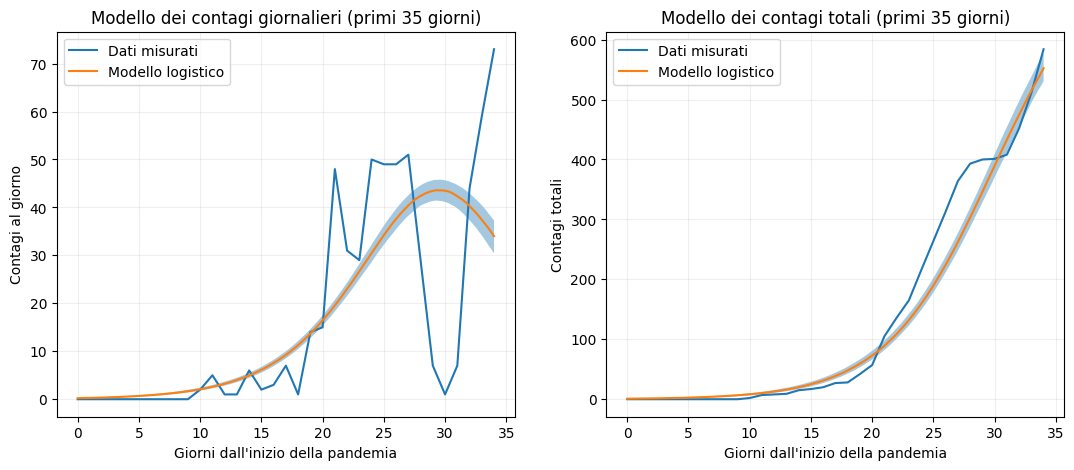

In [31]:
# Ora creiamo un grafico per vedere il risultato del modello in sè.
# Prendiamo un campione uniforme di 1000 elementi (parametri stimati) dalla catena per evitare
# di dover calcolare centinaia di migliaia di valori per ottenere un grafico.
# Dato che il campione è uniforme, ha la stessa distribuzione dei parametri stimati ed è dunque
# una comoda distillazione dei dati ottenuti tramite la catena.
# Calcoliamo poi i valori della logistica con quei parametri.
N_samples = 1000
x_arr = np.linspace(0, 34, 2000)
y_arr = np.zeros((2000, N_samples))
for i in range(N_samples):
    idx = np.random.randint(flat_samples.shape[0])
    est_t_0, est_k, est_N_tot = flat_samples[idx, :]
    y_arr[:, i] = contagi_giornalieri(logistic, x_arr, t_0=est_t_0, k=est_k, N_tot=est_N_tot)

# Prendiamo il modello migliore (50° percentile) e quelli ad una "deviazione standard"
# dal 50° percentile della distribuzione (16° e 84° percentili) per rappresentare l'intervallo
# di confidenza dei parametri del modello
y_arr_best_fit = np.percentile(y_arr, 50, axis=1)
y_arr_lower_estimate = np.percentile(y_arr, 16, axis=1)
y_arr_upper_estimate = np.percentile(y_arr, 84, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].plot(np.arange(0, 35), data_aosta_daily_early["nuovi_positivi"], label="Dati misurati")
axes[0].plot(x_arr, y_arr_best_fit, label="Modello logistico")
axes[0].fill_between(x_arr, y_arr_lower_estimate, y_arr_upper_estimate, alpha=0.4)
axes[0].set_title("Modello dei contagi giornalieri (primi 35 giorni)")
axes[0].set_xlabel("Giorni dall'inizio della pandemia")
axes[0].set_ylabel("Contagi al giorno")
axes[0].grid(alpha=0.2)
axes[0].legend()

# e controlliamo anche l'andamento nei casi totali, non solo quelli giornalieri
# Nota: qui si crea nuovamente il campione di 1000 parametri. Formalmente questo dà due
# modelli diversi e bisognerebbe usare lo stesso campione per entrambi i grafici, ma dato
# che la differenza tra due campioni così grandi è sufficientemente piccola da essere
# trascurabile, si rigenera il campione per tenere semplice il codice.
for i in range(N_samples):
    idx = np.random.randint(flat_samples.shape[0])
    est_t_0, est_k, est_N_tot = flat_samples[idx, :]
    y_arr[:, i] = logistic(x_arr, t_0=est_t_0, k=est_k, N_tot=est_N_tot)

y_arr_best_fit = np.percentile(y_arr, 50, axis=1)
y_arr_lower_estimate = np.percentile(y_arr, 16, axis=1)
y_arr_upper_estimate = np.percentile(y_arr, 84, axis=1)

axes[1].plot(np.arange(0, 35), data_aosta_daily_early["totale_casi"], label="Dati misurati")
axes[1].plot(x_arr, y_arr_best_fit, label="Modello logistico")
axes[1].fill_between(x_arr, y_arr_lower_estimate, y_arr_upper_estimate, alpha=0.4)
axes[1].set_title("Modello dei contagi totali (primi 35 giorni)")
axes[1].set_xlabel("Giorni dall'inizio della pandemia")
axes[1].set_ylabel("Contagi totali")
axes[1].grid(alpha=0.2)
axes[1].legend()

Qui si può vedere come il modello si paragona ai dati sperimentali.
1. Anzitutto vediamo come il modello fatica a rappresentare la grande variabilità dei contagi giornalieri, che possono variare da diverse decine a meno di dieci in appena una giornata. Considerando che l'unico dato utilizzato per il fit del modello sono i contagi giornalieri, trascurando i numerosi fattori sociali che possono portare ad un aumento o diminuzione di contagi, il risultato non sorpende ed è in generale una discreta rappresentazione dell'andamento. Il modello correttamente pone il picco di contagi verso l'estremo destro dell'intervallo, predicendo che i contagi giornalieri rimarranno alti ancora per un certo periodo.
2. Il fit dei contagi totali è invece molto più preciso. Tra i 10 e i 20 giorni sovrastima leggermente, mentre tra i 20 e i 30 presenta una sottostima non trascurabile, ma l'andamento è complessivamente corretto ed è un buon stimatore.
3. Il margine di incertezza sui parametri, raffigurato come la banda blu attorno al modello, è relativamente stretta, denotando che l'algoritmo emcee ha una buona certezza sui parametri stimati. Questo è specialmente vero nei contagi totali.

In [32]:
# Espandiamo l'intervallo di dati ai primi 100 giorni
data_aosta_daily_100 = data_aosta_daily[data_aosta_daily.index < data_aosta_daily.index[0] + pd.Timedelta(days=+99)]
data_aosta_daily_100.shape

(100, 29)

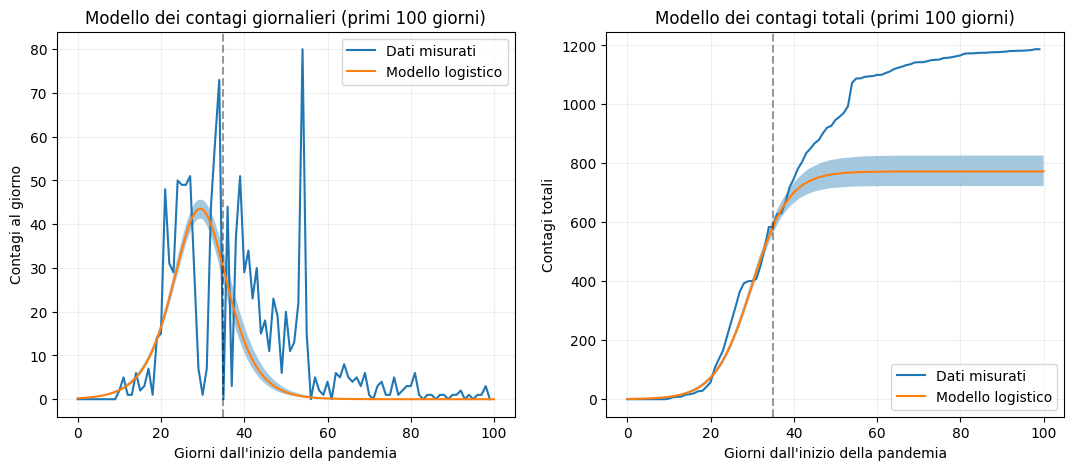

In [33]:
# Vediamo se il modello predice con buona precisione oltre l'intervallo di "addestramento"
x_arr = np.linspace(0, 100, 2000)
y_arr = np.zeros((2000, N_samples))
# Di nuovo, rigeneriamo il campione per semplicità
for i in range(N_samples):
    idx = np.random.randint(flat_samples.shape[0])
    est_t_0, est_k, est_N_tot = flat_samples[idx, :]
    y_arr[:, i] = contagi_giornalieri(logistic, x_arr, t_0=est_t_0, k=est_k, N_tot=est_N_tot)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].plot(np.arange(0, 100), data_aosta_daily_100["nuovi_positivi"], label="Dati misurati")
axes[0].plot(x_arr, np.percentile(y_arr, 50, axis=1), label="Modello logistico")
axes[0].fill_between(x_arr, np.percentile(y_arr, 16, axis=1), np.percentile(y_arr, 84, axis=1), alpha=0.4)
axes[0].axvline(35, linestyle="--", color="black", alpha=0.4)
axes[0].set_title("Modello dei contagi giornalieri (primi 100 giorni)")
axes[0].set_xlabel("Giorni dall'inizio della pandemia")
axes[0].set_ylabel("Contagi al giorno")
axes[0].grid(alpha=0.2)
axes[0].legend()

# e controlliamo anche l'andamento nei casi totali, non solo quelli giornalieri
for i in range(N_samples):
    idx = np.random.randint(flat_samples.shape[0])
    est_t_0, est_k, est_N_tot = flat_samples[idx, :]
    y_arr[:, i] = logistic(x_arr, t_0=est_t_0, k=est_k, N_tot=est_N_tot)

y_arr_best_fit = np.percentile(y_arr, 50, axis=1)
y_arr_lower_estimate = np.percentile(y_arr, 16, axis=1)
y_arr_upper_estimate = np.percentile(y_arr, 84, axis=1)

axes[1].plot(np.arange(0, 100), data_aosta_daily_100["totale_casi"], label="Dati misurati")
axes[1].plot(x_arr, y_arr_best_fit, label="Modello logistico")
axes[1].fill_between(x_arr, y_arr_lower_estimate, y_arr_upper_estimate, alpha=0.4)
axes[1].axvline(35, linestyle="--", color="black", alpha=0.4)
axes[1].set_title("Modello dei contagi totali (primi 100 giorni)")
axes[1].set_xlabel("Giorni dall'inizio della pandemia")
axes[1].set_ylabel("Contagi totali")
axes[1].grid(alpha=0.2)
axes[1].legend()

Qui si osservano l'affidabilità delle predizioni del modello logistico.
1. Salta all'occhio la grande ed evidente sottostima che il modello predice immediatamente dopo il periodo su cui è stato compiuto il fit, sia nel caso giornaliero che in quello cumulativo. In quello giornaliero il modello anticipa il quasi azzeramento dei contagi giornalieri di un periodo considerevole, quasi due settimane rispetto al giorno giusto (approssimativamente il 60° giorno). L'errore è ancora più marcato nei contagi totali, dove la curva si stabilizza a oltre 400 contagi totali in meno di quanto si è osservato.
2. Si dia attenzione al parametro $t_{0}$. Nella discussione sulle correlazioni tra i parametri si era fatto cenno a come $t_{0}$ rappresentasse il tempo mediano dell'epidemia o ondata in esame, e che il suo doppio $2t_{0}$ fosse la data in cui i contagi raggiungessero un minimo stabile. Per questo modello $t_{0}\approx30$ giorni, dunque la predizione è che l'ondata termini a 60 giorni dal suo inizio. I dati misurati danno credibilità a questa ipotesi: attorno ai 60 giorni si nota che i contagi giornalieri si sono abbassati ad un minimo dall'inizio dell'ondata e che rimangono stabilmente bassi\*. Questo suggerisce che la parametrizzazione usata sia complessivamente buona e che i valori trovati siano affidabili. Tuttavia, la curva utilizzata, la logistica, è inadatta a rappresentare questa genere di evoluzione nel tempo. Per questa ragione, il prossimo modello è basato sulla funzione di Gompertz.


\*È discutibile se porre il termine dell'ondata al 60° giorno sia ragionevole o un caso di bias di conferma. È altrettanto ragionevole dire che la fine dell'ondata accada attorno all'85° giorno, dove i casi non solo sono stabilmente bassi, ma anche tendenti allo 0. Tuttavia, credo che aggiungere la clausola di "tendenza allo 0 dei contagi" alla definizione di "termine di ondata" sia un'eccessiva restrizione, dato che le ondate che si osservano nella parte centrale della pandemia non raggiungono mai un valore prossimo allo zero. Una definizione del genere renderebbe impossibile isolare (almeno formalmente) le varie ondate centrali, che sono chiaramente visibili dai dati. Naturalmente, questa discussione a senso solo se definiamo l'ondata come un "picco di contagi giornalieri in un periodo relativamente breve".

## Modello di Gompertz
Ripetiamo lo stesso procedimento, ma utilizzando la funzione di Gompertz anziché quella logistica.

In [34]:
# Ridefiniamo la likelihood in funzione della curva di Gompertz

# Il prior è uguale a quello della funzione logistica
def log_prior(t_0: float, k: float, N_tot: int):
    if t_0 < 0 or k < 0 or N_tot < 0:
        return -np.inf
    return 0.0

# Nella likelihood cambia solo la funzione che usiamo per trovare i contagi giornalieri
def log_likelihood(t_0: float, k: float, N_tot: int, day_from_start: int, measured_cases: int):
    lam = contagi_giornalieri(gompertz, day_from_start, t_0=t_0, k=k, N_tot=N_tot)
    k_pois = measured_cases
    logfac = [np.sum(np.log(np.arange(2, k_i + 1))) for k_i in k_pois]
    return np.nansum(k_pois*np.log(lam) - lam - logfac)

# Il posterior è uguale a quello della funzione logistica
def log_posterior(params: list, day_from_start: int, measured_cases: int):
    t_0, k, N_tot = params
    prior = log_prior(t_0, k, N_tot)
    if not np.isfinite(prior):
        return -np.inf
    llh = log_likelihood(t_0, k, N_tot, day_from_start, measured_cases)
    return prior + llh

In [35]:
# Cerchiamo il minimo della funzione posterior per migliorare il punto di partenza dell'algoritmo emcee
starting_point = np.array([0, 0.1, 1000])
min_result = minimize(
    lambda *args: -log_posterior(*args),
    starting_point,
    args=(
        np.arange(0, 35), # Giorni dall'inizio della pandemia
        data_aosta_daily_early["nuovi_positivi"],
    ),
)
min_params = min_result.x
min_params

/run/media/dawnstar/vault/vault-home/Software/Python/analisi-covid-trmd/venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


array([1.07001656e+01, 9.65473155e-02, 1.14634956e+03])

In [36]:
# L'algoritmo emcee vero e proprio, calcolato sui dati dei prima 35 giorni
sampler = emcee.EnsembleSampler(32, 3, log_posterior, args=(np.arange(0, 35), data_aosta_daily_early["nuovi_positivi"]))
sampler.run_mcmc(min_params + 1e-2 * np.random.rand(32, 3), 4000, progress=True)

100%|████████████████████████████████████████████████████████████████████| 4000/4000 [00:39<00:00, 100.41it/s]


State([[9.45405285e+00 8.38276395e-02 1.27900344e+03]
 [9.99268626e+00 9.20965281e-02 1.17297717e+03]
 [1.17717319e+01 1.06137438e-01 1.02423231e+03]
 [1.14783612e+01 1.00871522e-01 1.10249434e+03]
 [1.01035314e+01 9.03189262e-02 1.14965468e+03]
 [9.60654236e+00 7.92947923e-02 1.67476796e+03]
 [9.36321390e+00 8.88708371e-02 1.20117357e+03]
 [1.08360158e+01 9.58524378e-02 1.09685860e+03]
 [9.32992220e+00 8.28011240e-02 1.47101648e+03]
 [9.74400221e+00 9.09236211e-02 1.22408238e+03]
 [1.10598689e+01 1.02609979e-01 9.99849299e+02]
 [1.03703415e+01 9.83496772e-02 1.22806257e+03]
 [9.82579149e+00 7.79171547e-02 1.76359776e+03]
 [1.09045909e+01 9.04663413e-02 1.35904770e+03]
 [1.02998134e+01 9.06564107e-02 1.24594911e+03]
 [1.06762909e+01 9.21231965e-02 1.19758116e+03]
 [1.16255173e+01 1.08490145e-01 1.13065707e+03]
 [9.85778249e+00 8.70357782e-02 1.42254068e+03]
 [9.99311636e+00 8.93436619e-02 1.28507646e+03]
 [9.70009799e+00 9.19632462e-02 1.17769354e+03]
 [1.06449793e+01 9.51046298e-02 1.

Text(0.5, 0, 'Numero di passi')

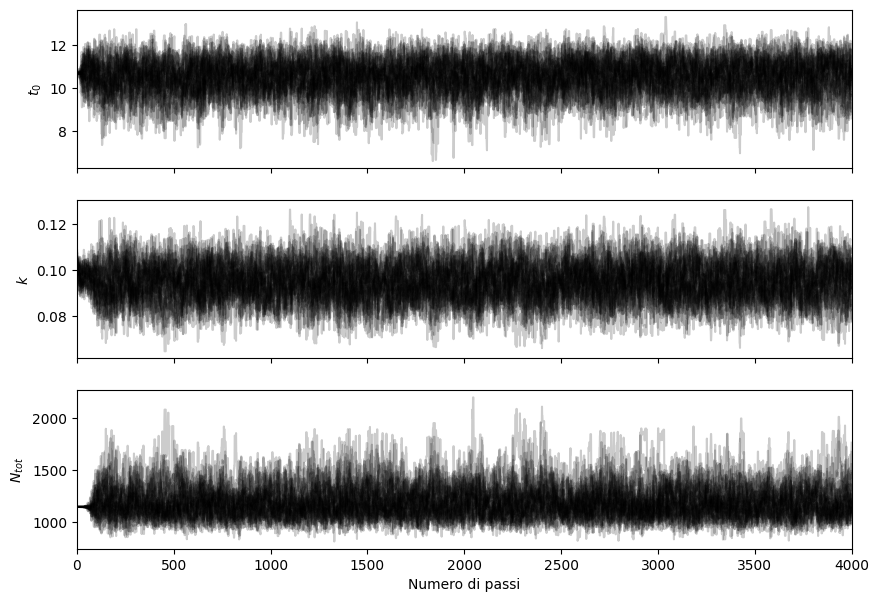

In [37]:
# Grafichiamo i risultati della catena di Monte Carlo
samples = sampler.get_chain()

dims = 3
fig, axes = plt.subplots(dims, figsize=(10, 7), sharex=True)
labels = ["$t_{0}$", "$k$", "$N_{tot}$"]
for i in range(dims):
    axes[i].plot(samples[:, :, i], "k", alpha=0.2)
    axes[i].set_xlim(0, len(samples))
    axes[i].set_ylabel(labels[i])

axes[-1].set_xlabel("Numero di passi")

Come prima, la minimizzazione ha aiutato. È interessante notare come $N_{tot}$ oscilla in un intervallo piuttosto ampio se paragonato al modello logistico.

In [38]:
# Controlliamo che il tempo di autocorrelazione sia sufficientemente alto
# (ossia che emcee non dia un errore)
tau = sampler.get_autocorr_time()
tau

array([39.73791337, 44.08315094, 45.82404833])

In [39]:
# Prendiamo i valori della catena, scartando i primi 100
flat_samples = sampler.get_chain(discard=100, flat=True)
flat_samples.shape

(124800, 3)

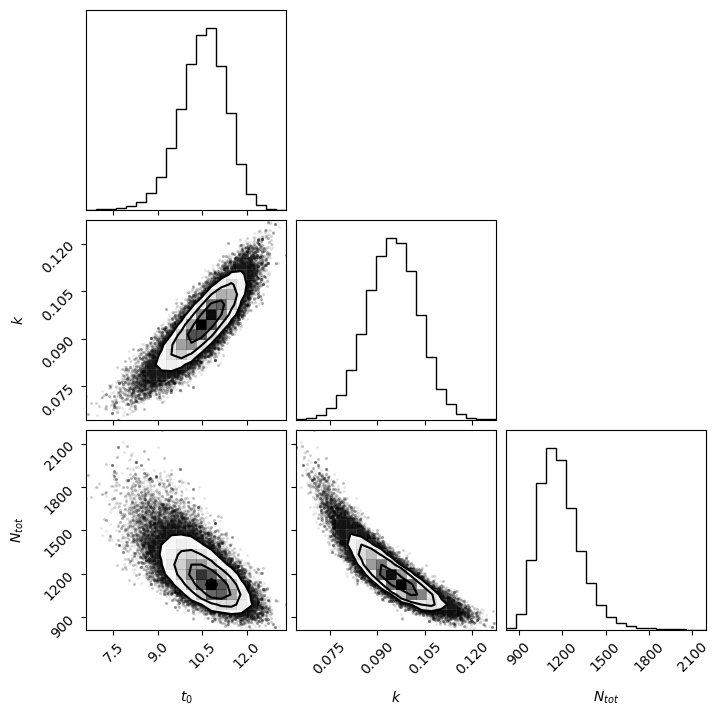

In [40]:
# Grafichiamo le combinazioni di parametri in modo da osservare le loro distribuzioni
# e notare possibili correlazioni fra di essi
fig = corner.corner(flat_samples, labels=labels)

Qui le correlazioni sono diverse. $k$ e $N_{tot}$ sono di nuovo anticorrelati, ma $k$ e $t_{0}$, e $N_{tot}$ e $t_{0}$ sono invertiti.
Nella funzione di Gompertz, $t_{0}$ non rappresenta più il punto di mezzo della pandemia, bensì l'inizio dei contagi. Prima di $t_{0}$ i contagi sono sostanzialmente nulli, quindi le interpretazioni fatte per la funzione logistica non si applicano a quella di Gompertz. Analizzare le correlazioni diventa più complesso: sebbene la metafora della candela si possa applicare anche qua, le altre due coppie sono meno chiare. L'anticorrelazione fra $t_{0}$ e $N_{tot}$ può trovare spiegazione nel fatto che un inizio dei contagi spostato più avanti nel futuro concede più tempo per preparare misure per contrastare l'espansione, ma è difficile credere che il modello esprima concetti di questo tipo dai dati limitati che su cui è stato creato. Una correlazione positiva tra $t_{0}$ e $k$ è anch'essa difficile da giustificare senza far subentrare concetti ulteriori, come per esempio l'asintomaticità (importante per il COVID) o un periodo di incubazione che permetta alla malattia di diffondersi senza che gli infetti se ne accorgano e che poi si manifesti in massa dopo un certo periodo (ricordiamo che i dati su cui è fittato il modello sono i contagi *dichiarati*, un individuo che non si accorge di essere infetto non farebbe parte del dataset). Questo suggerisce che la curva logistica potrebbe essere più adatta a modellare malattie "evidenti", ossia quelle che mostrano sintomi chiari, in poco tempo e con basso o nullo tasso di asintomaticità, mentre la curva di Gompertz potrebbe essere migliore a modellare malattie che si diffondono con sintomi non sempre chiari o talvolta inesistenti, che è il caso del COVID.

In [41]:
# Troviamo i parametri più affidabili
t_0_best_fit, k_best_fit, N_tot_best_fit = np.percentile(flat_samples, 50, axis=0)
t_0_best_fit, k_best_fit, N_tot_best_fit

(10.58265832183221, 0.09511121816207792, 1170.4343058600534)

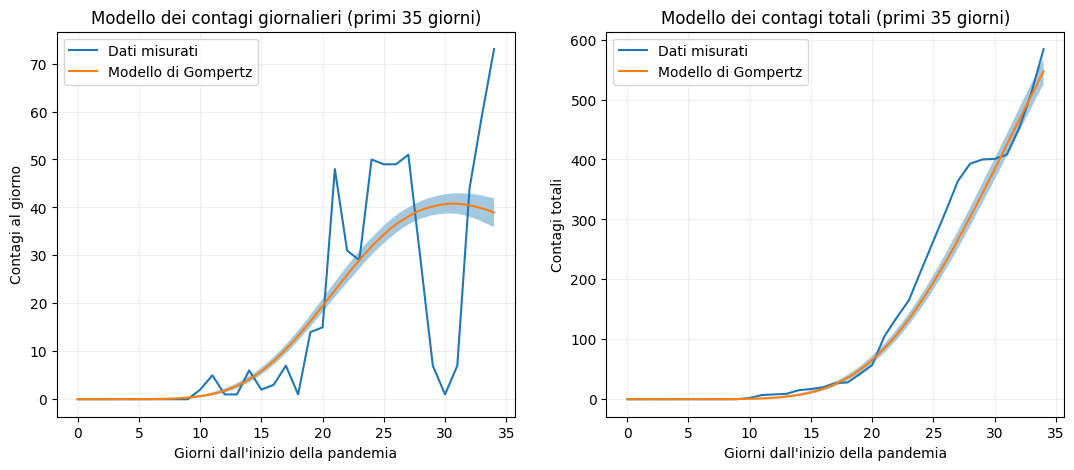

In [42]:
# Ora creiamo un grafico per vedere il risultato del modello in sè.
# Qui usiamo la funzione di Gompertz anziché la logistica
N_samples = 1000
x_arr = np.linspace(0, 34, 2000)
y_arr = np.zeros((2000, N_samples))
for i in range(N_samples):
    idx = np.random.randint(flat_samples.shape[0])
    est_t_0, est_k, est_N_tot = flat_samples[idx, :]
    y_arr[:, i] = contagi_giornalieri(gompertz, x_arr, t_0=est_t_0, k=est_k, N_tot=est_N_tot)

# Prendiamo il modello migliore (50° percentile) e quelli ad una "deviazione standard"
# dal 50° percentile della distribuzione (16° e 84° percentili)
y_arr_best_fit = np.percentile(y_arr, 50, axis=1)
y_arr_lower_estimate = np.percentile(y_arr, 16, axis=1)
y_arr_upper_estimate = np.percentile(y_arr, 84, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].plot(np.arange(0, 35), data_aosta_daily_early["nuovi_positivi"], label="Dati misurati")
axes[0].plot(x_arr, y_arr_best_fit, label="Modello di Gompertz")
axes[0].fill_between(x_arr, y_arr_lower_estimate, y_arr_upper_estimate, alpha=0.4)
axes[0].set_title("Modello dei contagi giornalieri (primi 35 giorni)")
axes[0].set_xlabel("Giorni dall'inizio della pandemia")
axes[0].set_ylabel("Contagi al giorno")
axes[0].grid(alpha=0.2)
axes[0].legend()

# e controlliamo anche l'andamento nei casi totali, non solo quelli giornalieri
for i in range(N_samples):
    idx = np.random.randint(flat_samples.shape[0])
    est_t_0, est_k, est_N_tot = flat_samples[idx, :]
    y_arr[:, i] = gompertz(x_arr, t_0=est_t_0, k=est_k, N_tot=est_N_tot)

y_arr_best_fit = np.percentile(y_arr, 50, axis=1)
y_arr_lower_estimate = np.percentile(y_arr, 16, axis=1)
y_arr_upper_estimate = np.percentile(y_arr, 84, axis=1)

axes[1].plot(np.arange(0, 35), data_aosta_daily_early["totale_casi"], label="Dati misurati")
axes[1].plot(x_arr, y_arr_best_fit, label="Modello di Gompertz")
axes[1].fill_between(x_arr, y_arr_lower_estimate, y_arr_upper_estimate, alpha=0.4)
axes[1].set_title("Modello dei contagi totali (primi 35 giorni)")
axes[1].set_xlabel("Giorni dall'inizio della pandemia")
axes[1].set_ylabel("Contagi totali")
axes[1].grid(alpha=0.2)
axes[1].legend()

Il modello di Gompertz nei primi 35 giorni è paragonabile a quello logistico, con un'analisi molto simile. I parametri sono stimati con buona precisione e i casi totali sono approssimati molto meglio di quanto non siano i casi giornalieri. Tuttavia, si possono già vedere dei miglioramenti: nel caso dei contagi totali, la funzione di Gompertz ha risolto il problema della sottostima tra il 10° e il 20° giorno e diminuito la sottostima tra il 20° e il 30°; nei casi giornalieri, il picco della funzione è spostato più in avanti (nel senso dei giorni) rispetto alla logistica, che si era vista sottostimare i contagi al di fuori dei primi 35 giorni. Questo dà speranza che la funzione di Gompertz non faccia lo stesso errore.

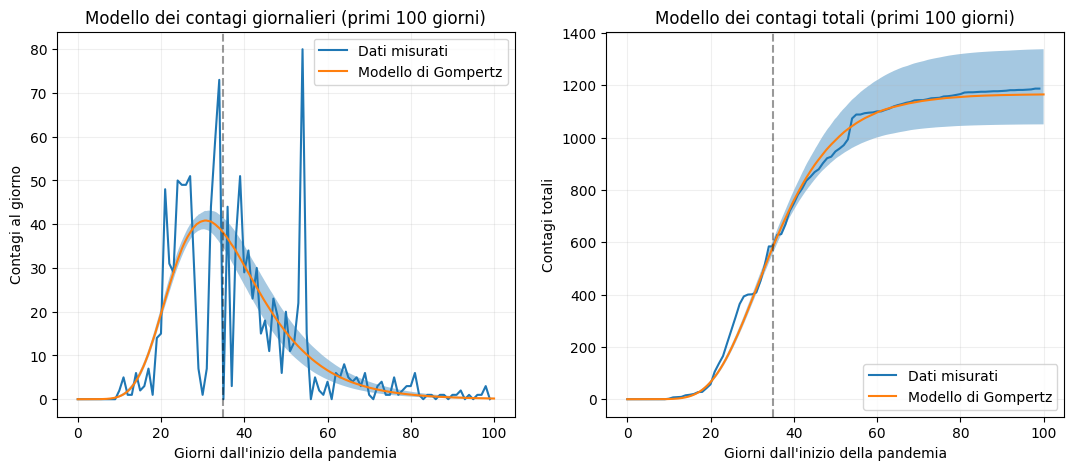

In [43]:
# Vediamo se il modello predice con buona precisione oltre l'intervallo di "addestramento"
x_arr = np.linspace(0, 100, 2000)
y_arr = np.zeros((2000, N_samples))
for i in range(N_samples):
    idx = np.random.randint(flat_samples.shape[0])
    est_t_0, est_k, est_N_tot = flat_samples[idx, :]
    y_arr[:, i] = contagi_giornalieri(gompertz, x_arr, t_0=est_t_0, k=est_k, N_tot=est_N_tot)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].plot(np.arange(0, 100), data_aosta_daily_100["nuovi_positivi"], label="Dati misurati")
axes[0].plot(x_arr, np.percentile(y_arr, 50, axis=1), label="Modello di Gompertz")
axes[0].fill_between(x_arr, np.percentile(y_arr, 16, axis=1), np.percentile(y_arr, 84, axis=1), alpha=0.4)
axes[0].axvline(35, linestyle="--", color="black", alpha=0.4)
axes[0].set_title("Modello dei contagi giornalieri (primi 100 giorni)")
axes[0].set_xlabel("Giorni dall'inizio della pandemia")
axes[0].set_ylabel("Contagi al giorno")
axes[0].grid(alpha=0.2)
axes[0].legend()

# e controlliamo anche l'andamento nei casi totali, non solo quelli giornalieri
for i in range(N_samples):
    idx = np.random.randint(flat_samples.shape[0])
    est_t_0, est_k, est_N_tot = flat_samples[idx, :]
    y_arr[:, i] = gompertz(x_arr, t_0=est_t_0, k=est_k, N_tot=est_N_tot)

y_arr_best_fit = np.percentile(y_arr, 50, axis=1)
y_arr_lower_estimate = np.percentile(y_arr, 16, axis=1)
y_arr_upper_estimate = np.percentile(y_arr, 84, axis=1)

axes[1].plot(np.arange(0, 100), data_aosta_daily_100["totale_casi"], label="Dati misurati")
axes[1].plot(x_arr, y_arr_best_fit, label="Modello di Gompertz")
axes[1].fill_between(x_arr, y_arr_lower_estimate, y_arr_upper_estimate, alpha=0.4)
axes[1].axvline(35, linestyle="--", color="black", alpha=0.4)
axes[1].set_title("Modello dei contagi totali (primi 100 giorni)")
axes[1].set_xlabel("Giorni dall'inizio della pandemia")
axes[1].set_ylabel("Contagi totali")
axes[1].grid(alpha=0.2)
axes[1].legend(loc="lower right")

Come si può vedere, il modello basato sulla funzione di Gompertz non solo è molto migliore rispetto a quello basato sulla logistica, ma è anche uno stimatore quasi perfetto dell'andamento sia dei contagi totali, sia di quelli giornalieri (trascurando ovviamente l'enorme variabilità di questi).
1. Questo modello non è affetto dal problema di sottostima che rende quello logistico pressoché inutilizzabile. La predizione più affidabile del numero totale di contagi è in linea con quanto osservato nelle misure reali e la curva stimata rimane vicino a quella reale per tutti i primi 100 giorni.
2. Come si era già notato nella catena di Montecarlo, il parametro $N_{tot}$ non è molto affidabile e si ha un'ampia banda di possibili stime a contagi alti.
3. Il fatto che il modello di Gompertz rappresenti così bene l'andamento dell'ondata dà credito all'affermazione precedente sul fatto che la curva di Gompertz sia adatta a modellare malattie con casi di asintomaticità. Chiaramente questa non è una prova sufficiente per dire con certezza che ciò sia vero, ma è un punto a suo favore.

# Parte 4
Espandiamo l'analisi ad un periodo più ampio e avanzato nella pandemia.

In [44]:
# Consideriamo il periodo tra il 03/06/2020 e il 03/06/2021
data_aosta_daily_mid = data_aosta_daily[
    (data_aosta_daily.index > Timestamp(year=2020, month=6, day=3))
    & (data_aosta_daily.index < Timestamp(year=2021, month=6, day=3))
]
data_aosta_daily_mid.shape

(365, 29)

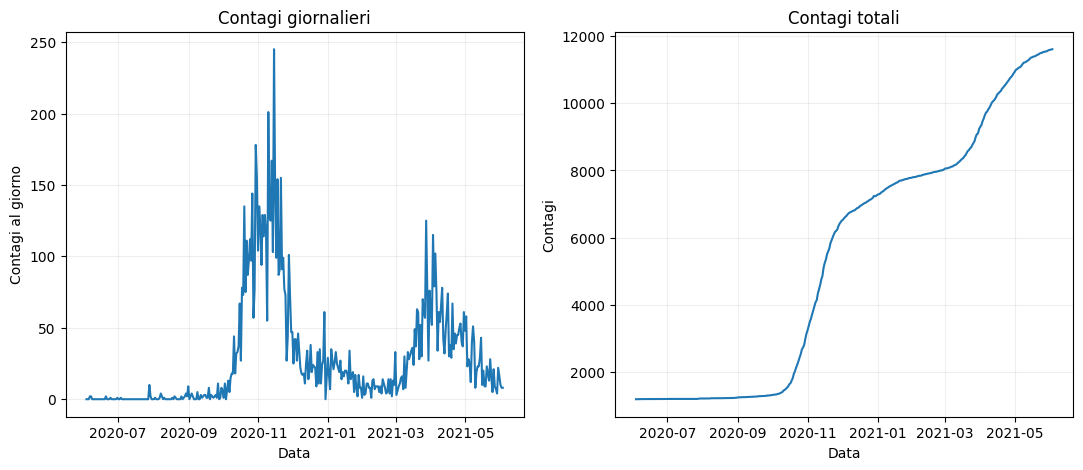

In [45]:
# Diamo un occhio ai dati
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].plot(data_aosta_daily_mid["nuovi_positivi"])
axes[0].set_title("Contagi giornalieri")
axes[0].set_xlabel("Data")
axes[0].set_ylabel("Contagi al giorno")
axes[0].grid(alpha=0.2)

axes[1].plot(data_aosta_daily_mid["totale_casi"])
axes[1].set_title("Contagi totali")
axes[1].set_xlabel("Data")
axes[1].set_ylabel("Contagi")
axes[1].grid(alpha=0.2)

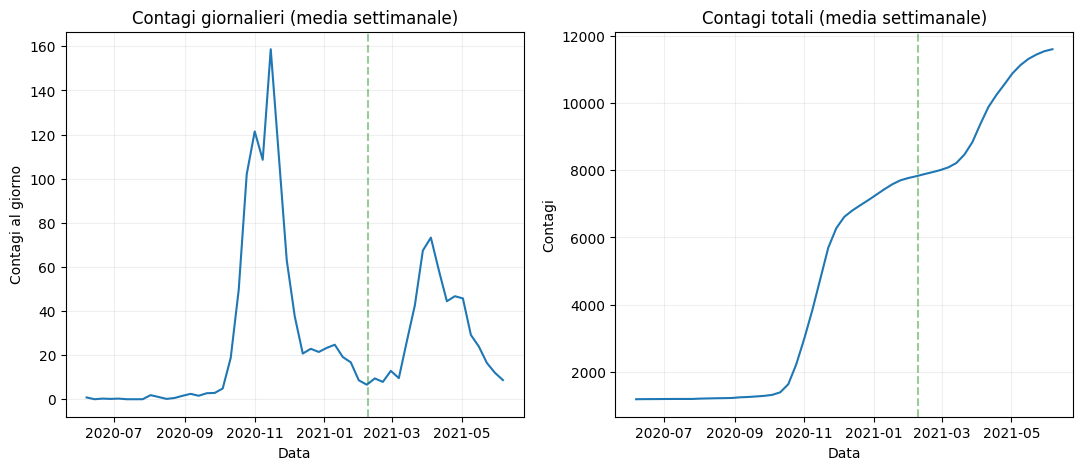

In [46]:
# I dati sono molto rumorosi, quindi usiamo la media settimanale
data_aosta_weekly_mid = data_aosta_daily_mid.resample("W")

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].plot(data_aosta_weekly_mid["nuovi_positivi"].mean())
axes[0].set_title("Contagi giornalieri (media settimanale)")
axes[0].set_xlabel("Data")
axes[0].set_ylabel("Contagi al giorno")
axes[0].axvline(Timestamp(year=2021, month=2, day=8), linestyle="--", color="green", alpha=0.4)
axes[0].grid(alpha=0.2)

axes[1].plot(data_aosta_weekly_mid["totale_casi"].mean())
axes[1].set_title("Contagi totali (media settimanale)")
axes[1].set_xlabel("Data")
axes[1].set_ylabel("Contagi")
axes[1].axvline(Timestamp(year=2021, month=2, day=8), linestyle="--", color="green", alpha=0.4)
axes[1].grid(alpha=0.2)

Il periodo di un anno tra giugno 2020 e giugno 2021 è caratterizzato dalla presenza di due ondate separate, qui divise approssimativamente dalla linea verticale verde. Come si è visto all'inizio dell'analisi, sia la funzione logistica che la funzione di Gompertz hanno un solo punto di flesso e le loro derivate (i contagi giornalieri) hanno un solo picco. Di conseguenza, esse sono adatte a modellare l'andamento di una sola ondata alla volta. Per analizzare l'evolversi dell'epidemia in questo periodo è dunque ideale spezzare il periodo in due, circa alla linea tratteggiata verde, in modo da isolare le due ondate e modellarle separatamente usando gli stessi metodi già trovati nella parte 3. Inoltre, è chiaro che sia auspicabile continuare ad utilizzare la funzione di Gompertz come base del modello visti gli ottimi risultati nella prima ondata. Infine, dato che la curva di Gompertz rimane piatta fino al momento $t_{0}$, è anche in grado di modellare con facilità il periodo di bassi contagi nei primi tre mesi del grafico (06/2020 ai 09/2020) in quanto basta porre $t_{0}$ più avanti nel tempo (la logistica, d'altro canto, farebbe più fatica).

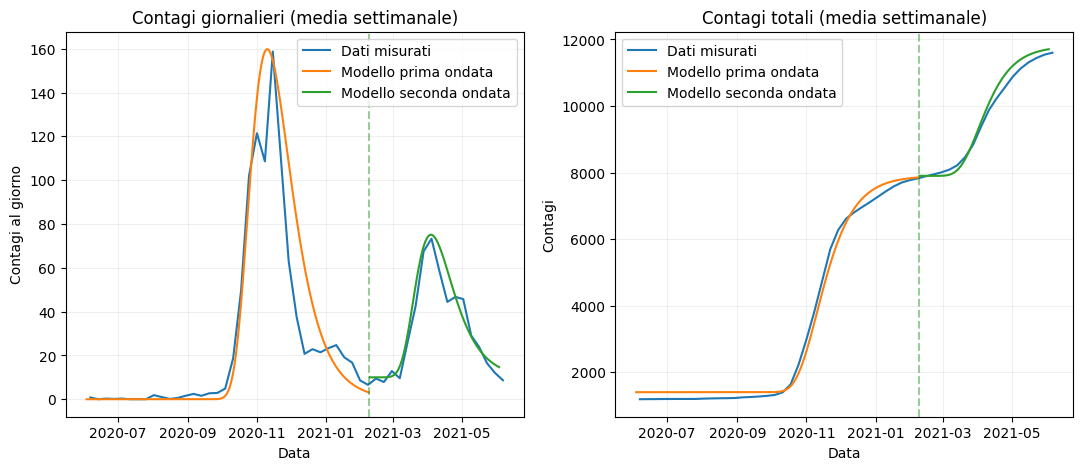

In [47]:
# Cerchiamo due modelli basati sulla funzione di Gompertz facendoli a mano, come semplice test di validità
data_wave_1 = data_aosta_daily_mid[data_aosta_daily_mid.index < Timestamp(2021, 2, 8)]
data_wave_2 = data_aosta_daily_mid[data_aosta_daily_mid.index >= Timestamp(2021, 2, 8)]

# I parametri scelti a mano dei due modelli
t_0_1 = Timestamp(2020, 10, 1)
k_1 = 0.055
N_tot_1 = 7900

t_0_2 = Timestamp(2021, 2, 25)
k_2 = 0.06
N_tot_2 = 11800

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].plot(data_aosta_weekly_mid["nuovi_positivi"].mean(), label="Dati misurati")
axes[0].plot(
    data_wave_1.index,
    contagi_giornalieri(
        gompertz,
        data_wave_1.index,
        t_0=t_0_1,
        k=k_1,
        N_tot=N_tot_1,
    ),
    label="Modello prima ondata",
)
axes[0].plot(
    data_wave_2.index,
    # Scaliamo e aggiungiamo un fattore "di fondo" alla funzione
    10 + 0.25*contagi_giornalieri(
        gompertz,
        data_wave_2.index,
        t_0=t_0_2,
        k=k_2,
        N_tot=N_tot_2,
    ),
    label="Modello seconda ondata",
)
axes[0].set_title("Contagi giornalieri (media settimanale)")
axes[0].set_xlabel("Data")
axes[0].set_ylabel("Contagi al giorno")
axes[0].axvline(Timestamp(year=2021, month=2, day=8), linestyle="--", color="green", alpha=0.4)
axes[0].grid(alpha=0.2)
axes[0].legend()

axes[1].plot(data_aosta_weekly_mid["totale_casi"].mean(), label="Dati misurati")
axes[1].plot(
    data_wave_1.index,
    # Anche qui aggiungiamo un fattore di fondo
    1400 + gompertz(
        data_wave_1.index,
        t_0=t_0_1,
        k=k_1,
        N_tot=N_tot_1 - 1400, # e ne teniamo conto nella funzione
    ),
    label="Modello prima ondata",
)
axes[1].plot(
    data_wave_2.index,
    # e anche qui
    7900 + gompertz(
        data_wave_2.index,
        t_0=t_0_2,
        k=k_2,
        N_tot=N_tot_2 - 7900, # e qui
    ),
    label="Modello seconda ondata",
)
axes[1].set_title("Contagi totali (media settimanale)")
axes[1].set_xlabel("Data")
axes[1].set_ylabel("Contagi")
axes[1].axvline(Timestamp(year=2021, month=2, day=8), linestyle="--", color="green", alpha=0.4)
axes[1].grid(alpha=0.2)
axes[1].legend()

Queste sono due bozze di modelli epidemiologici basati sulla funzione di Gompertz, calibrati a mano senza usare l'algoritmo emcee. Si nota subito che anche qui, pur usando una grezza realizzazione manuale, sono approssimazioni piuttosto buone, in accordo con quanto trovato nei risultati precedenti. Tuttavia, per raggiungere questi modelli, si sono dovuti fare calcoli aggiuntivi rispetto a quanto fatto in precedenza.

Si sono dovuti fare due cambiamenti per raggiungere questo risultato. I parametri della curva di Gompertz rimagono gli stessi ($t_{0}$, $k$ e $N_{tot}$), ma è stato necessario riscalare la curva di una costante e aggiungere un valore di fondo. In particolare, i contagi giornalieri della prima ondata non hanno richiesto modifiche, ma quelli della seconda ondata sono dovuti essere moltiplicati per 0.25 e aumentati di 10 per raggiungere la funzione nel grafico. In modo simile, entrambe le stime dei contagi complessivi sono traslate di un certo valore.

Nel caso dei contagi totali, la traslazione è facilmente comprensibile. La funzione di Gompertz, matematicamente, vale circa zero per valori $<t_{0}$, ma facendo un modello a epidemia già avanzata, il numero di contagi totali fino a quel momento sicuramente non sarà zero. Dunque, la funzione di Gompertz va traslata di un valore pari al numero di contagi complessivi al momento di inizio del modello, in modo da rendere quel valore il "nuovo zero" della funzione. Questo si può fare perché si stanno modellando le ondate in modo indipendente, dunque la traslazione serve a trascurare gli effetti delle ondate precedenti. Questo *non* è un nuovo parametro del modello: è una costante conosciuta a priori, ottenuta dai dati, che si aggiunge separatamente ai calcoli. Il modello rimane dipendente dalle stesse variabili.

I contagi giornalieri sono più complessi. La prima ondata in realtà non ha avuto bisogno di variazioni manuali; questo è in linea con quanto trovato in precedenza. La seconda ondata ha avuto bisogno di essere sia traslata, sia riscalata. Come si spiega questa anomalia? Cominciamo dalla parte facile: la traslazione è stata compiuta per gli stessi motivi dei contagi totali. Al termine della prima ondata, i contagi giornalieri si sono abbassati, ma non azzerati. Di conseguenza, il valore di partenza della seconda ondata *non* può essere 0, bensì deve essere il valore a cui si è stabilizzata la prima ondata (in questo caso circa 10 contagi al giorno). Per quanto riguarda la constante di scala, senza riscalare il numero di contagi è di gran lunga più alto di quanto ci si ritrovi nella realtà. La ragione (o perlomeno parte di essa) è da cercare nello sviluppo di immunità e la vicinanza tra le ondate. Dopo essere stato infettato, l'individuo sviluppa un'immunità (temporanea) alla malattia. Subito dopo un'ondata, una considerevole parte della popolazione sarà resa immune, il che diminuisce di molto la popolazione suscettibile ad essere infetta. Ciò significa che la vicinanza ad un'altra ondata "sopprime" il sorgere di una seconda immediatamente successiva, come si vede da questi dati. Si può dire quindi che, a differenza della traslazione, la costante di scala può essere aggiunta come un quarto parametro al modello ed essere chiamata "fattore di suscettibilità" $S$, o un concetto simile, che tiene conto della prossimità di altre ondate e della loro gravità. Si dovrebbero rivedere tuttavia i calcoli del modello per tenere conto di questo nuovo parametro. Va notato che $S$ è presente solo nella derivata (i contagi al giorno) e non nella funzione di Gompertz stessa.

# Conclusioni
Si è analizzata l'evoluzione della pandemia COVID-19 nella regione Val d'Aosta, considerando sia l'andamento dei contagi giornalieri, sia quelli cumulativi. È stata utilizzata l'inferenza bayesiana per creare modelli statistici per la predizione dell'andamento di singole ondate, utilizzando sia la funzione logistica, sia la funzione di Gompertz. Si è trovato che la funzione di Gompertz produce modelli realistici e affidabili che descrivono con ottima precisione l'evoluzione di un'ondata epidemiologica, e che la funzione logistica tende a sottostimare gravemente l'effetto di un'ondata al di fuori dell'intervallo su cui sono stati testati i parametri. Si è discussa l'interpretazione delle forti correlazioni trovate fra i parametri dei modelli e sono state date alcune ipotesi sul significato pratico dei parametri stimati, in particolare considerando l'aspetto pratico e sociale dei parametri e le limitazioni di questi modelli. Si è notato che la funzione logistica e quella di Gompertz presentano correlazioni diverse fra parametri, una possibile ragione per la differenza di precisione tra le due. Infine, si è esteso lo studio a ondate ulteriori alla prima e si è osservata la necessità di aggiungere termini di traslazione e scala ai modelli per poterli applicare a ondate successive alla prima, trovando che la traslazione è un dato conosciuto a priori e che la scala può essere aggiunta come un ulteriore parametro al modello che tiene conto della vicinanza ad altre ondate.